In [22]:
!pip install eefolium tensorflow rasterio

In [27]:
"""Memory-Optimized Wildfire Classification"""
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, applications
import numpy as np
from tensorflow.keras.preprocessing import image_dataset_from_directory
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report, confusion_matrix

In [2]:
# Configuration
DATA_DIR = "/content/drive/MyDrive/FIRMS_Data"
SPLIT_RATIO = (0.7, 0.2, 0.1)  # Train, Val, Test
SEED = 42

# Create destination folders
for split in ['train', 'val', 'test']:
    for cls in ['fire', 'no_fire']:
        os.makedirs(os.path.join(DATA_DIR, split, cls), exist_ok=True)

# Process each class
for class_name in ['fire', 'no_fire']:
    src_dir = os.path.join(DATA_DIR, class_name)
    files = [f for f in os.listdir(src_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    # First split: train+val vs test
    train_val_files, test_files = train_test_split(
        files,
        test_size=SPLIT_RATIO[2],
        random_state=SEED
    )

    # Second split: train vs val
    train_files, val_files = train_test_split(
        train_val_files,
        test_size=SPLIT_RATIO[1]/(SPLIT_RATIO[0]+SPLIT_RATIO[1]),
        random_state=SEED
    )

    # Copy files to destination folders
    for f in train_files:
        shutil.copy(
            os.path.join(src_dir, f),
            os.path.join(DATA_DIR, 'train', class_name, f)
        )

    for f in val_files:
        shutil.copy(
            os.path.join(src_dir, f),
            os.path.join(DATA_DIR, 'val', class_name, f)
        )

    for f in test_files:
        shutil.copy(
            os.path.join(src_dir, f),
            os.path.join(DATA_DIR, 'test', class_name, f)
        )

print("Dataset splitting completed!")

Dataset splitting completed!


In [3]:
# Configuration
DATA_DIR = "/content/drive/MyDrive/FIRMS_Data"
IMG_SIZE = (256, 256)  # Reduced from original to save memory
BATCH_SIZE = 32

# Elastic Net regularization parameters
L1 = 0.0005
L2 = 0.0005

# Load datasets
train_ds = image_dataset_from_directory(
    f'{DATA_DIR}/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

val_ds = image_dataset_from_directory(
    f'{DATA_DIR}/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_ds = image_dataset_from_directory(
    f'{DATA_DIR}/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

Found 286 files belonging to 2 classes.
Found 84 files belonging to 2 classes.
Found 43 files belonging to 2 classes.


In [4]:
# Calculate class weights
fire_count = len(os.listdir(f'{DATA_DIR}/train/fire'))
no_fire_count = len(os.listdir(f'{DATA_DIR}/train/no_fire'))
total = fire_count + no_fire_count
class_weight = {
    0: (1 / no_fire_count) * (total / 2.0),  # no_fire
    1: (1 / fire_count) * (total / 2.0)       # fire
}


In [7]:
# Simple model with Elastic Net regularization
model = models.Sequential([
    # Basic augmentation
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    # Base network
    layers.Rescaling(1./255),
    layers.Conv2D(32, (3, 3), activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=L1, l2=L2)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3, 3), activation='relu',
                 kernel_regularizer=regularizers.l1_l2(l1=L1, l2=L2)),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(64, activation='relu',
                kernel_regularizer=regularizers.l1_l2(l1=L1, l2=L2)),
    layers.Dropout(0.5),

    layers.Dense(1, activation='sigmoid')
])



In [8]:
# Custom learning rate with decay
optimizer = tf.keras.optimizers.Adam(
    learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=1e-3,
        decay_steps=1000,
        decay_rate=0.9
    )
)



In [9]:
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)



In [10]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_auc',
        mode='max',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.keras',
        save_best_only=True,
        monitor='val_auc'
    )
]



In [13]:
# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weight,
    callbacks=callbacks
)



Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6911 - auc: 0.6947 - loss: 1.9180 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7024 - val_auc: 0.6993 - val_loss: 1.9288 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7180 - auc: 0.7077 - loss: 1.8360 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7024 - val_auc: 0.6858 - val_loss: 1.8133 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 878ms/step - accuracy: 0.7226 - auc: 0.6968 - loss: 1.7671 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7024 - val_auc: 0.6797 - val_loss: 1.7836 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6978 - auc: 0.7727 - loss: 1.6790 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7024 - val_auc: 0.6858 - val_loss: 1.7350 - val_precision: 0.0000e+00 - val_rec

In [12]:
# Evaluate on test set
test_results = model.evaluate(test_ds)
print(f"\nTest Performance:\n"
      f"Loss: {test_results[0]:.4f}\n"
      f"Accuracy: {test_results[1]:.4f}\n"
      f"Precision: {test_results[2]:.4f}\n"
      f"Recall: {test_results[3]:.4f}\n"
      f"AUC: {test_results[4]:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7151 - auc: 0.7197 - loss: 1.9554 - precision: 0.0000e+00 - recall: 0.0000e+00

Test Performance:
Loss: 1.9659
Accuracy: 0.6977
Precision: 0.0000
Recall: 0.0000
AUC: 0.7385


In [15]:
# Configuration
DATA_DIR = "/content/drive/MyDrive/FIRMS_Data"
IMG_SIZE = (224, 224)  # Standard size for MobileNetV2
BATCH_SIZE = 32

# Load datasets with caching/prefetch
train_ds = image_dataset_from_directory(
    f'{DATA_DIR}/train',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
).cache().prefetch(tf.data.AUTOTUNE)

val_ds = image_dataset_from_directory(
    f'{DATA_DIR}/val',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
).cache().prefetch(tf.data.AUTOTUNE)



Found 286 files belonging to 2 classes.
Found 84 files belonging to 2 classes.


In [16]:
# Calculate class weights
fire_count = len(os.listdir(f'{DATA_DIR}/train/fire'))
no_fire_count = len(os.listdir(f'{DATA_DIR}/train/no_fire'))
total = fire_count + no_fire_count
class_weight = {0: 1/(no_fire_count/total), 1: 1/(fire_count/total)}



In [17]:
# Focal loss implementation
def focal_loss(gamma=2.0, alpha=0.25):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        ce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-ce)
        return tf.reduce_mean(alpha * (1-pt)**gamma * ce)
    return loss



In [18]:
# Model construction
base_model = applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

model = models.Sequential([
    # Strategic augmentation
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),

    # Preprocessing
    layers.Rescaling(1./127.5, offset=-1),  # MobileNet scaling

    # Base model
    base_model,

    # Custom head
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Freeze base model initially
base_model.trainable = False



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
# Initial compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=focal_loss(),
    metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)



In [20]:
# Phase 1: Train the head
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weight
)



Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - auc: 0.4960 - loss: 0.3638 - precision: 0.2920 - recall: 0.5301 - val_auc: 0.4925 - val_loss: 0.1182 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - auc: 0.5476 - loss: 0.2742 - precision: 0.3625 - recall: 0.1553 - val_auc: 0.5339 - val_loss: 0.0517 - val_precision: 0.2083 - val_recall: 0.2000
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - auc: 0.5430 - loss: 0.2361 - precision: 0.3163 - recall: 0.4568 - val_auc: 0.5583 - val_loss: 0.0518 - val_precision: 0.2308 - val_recall: 0.1200
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - auc: 0.5498 - loss: 0.2462 - precision: 0.3333 - recall: 0.3215 - val_auc: 0.5742 - val_loss: 0.0622 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - auc: 0.7087 - loss: 0.1677 - precision: 0.4862 - recall: 0.2979 - val_auc: 0.5875 - val_loss: 0.0476 - val_precision: 0.3043 - val_recall: 0.2800


In [21]:
# Phase 2: Fine-tune entire model
base_model.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=focal_loss(),
    metrics=[
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)



In [22]:
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    class_weight=class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=3,
            restore_best_weights=True
        )
    ]
)



Epoch 1/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 44s 769ms/step - auc: 0.6315 - loss: 0.1921 - precision: 0.4194 - recall: 0.5627 - val_auc: 0.6515 - val_loss: 0.0500 - val_precision: 0.3810 - val_recall: 0.3200
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - auc: 0.6804 - loss: 0.1619 - precision: 0.4380 - recall: 0.5012 - val_auc: 0.6566 - val_loss: 0.0507 - val_precision: 0.3810 - val_recall: 0.3200
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 275ms/step - auc: 0.6209 - loss: 0.1658 - precision: 0.3750 - recall: 0.4217 - val_auc: 0.6597 - val_loss: 0.0511 - val_precision: 0.4091 - val_recall: 0.3600
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 290ms/step - auc: 0.6817 - loss: 0.1507 - precision: 0.4305 - recall: 0.5661 - val_auc: 0.6600 - val_loss: 0.0513 - val_precision: 0.4091 - val_recall: 0.3600
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 269ms/step - auc: 0.6395 - loss: 0.1724 - precision: 0.4262 - recall: 0.5449 - val_auc: 0.6593 - val_loss: 0.0516 - val_precision: 0.4091 - val_recall: 0.3600
Epoch 6/2

In [28]:
# Post-training threshold optimization
val_preds = model.predict(val_ds)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

thresholds = np.linspace(0.1, 0.5, 20)
best_f1 = 0
best_threshold = 0.5

for thresh in thresholds:
    preds = (val_preds > thresh).astype(int)
    f1 = f1_score(val_labels, preds)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh

print(f"Optimal threshold: {best_threshold:.2f}")



3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Optimal threshold: 0.18


In [29]:
# Final evaluation with optimal threshold
test_ds = image_dataset_from_directory(
    f'{DATA_DIR}/test',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

test_preds = model.predict(test_ds)
test_preds = (test_preds > best_threshold).astype(int)
test_labels = np.concatenate([y for x, y in test_ds], axis=0)

print("\nClassification Report:")
print(classification_report(test_labels, test_preds))
print("\nConfusion Matrix:")
print(confusion_matrix(test_labels, test_preds))

Found 43 files belonging to 2 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step

Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.10      0.18        30
         1.0       0.31      0.92      0.46        13

    accuracy                           0.35        43
   macro avg       0.53      0.51      0.32        43
weighted avg       0.62      0.35      0.26        43


Confusion Matrix:
[[ 3 27]
 [ 1 12]]


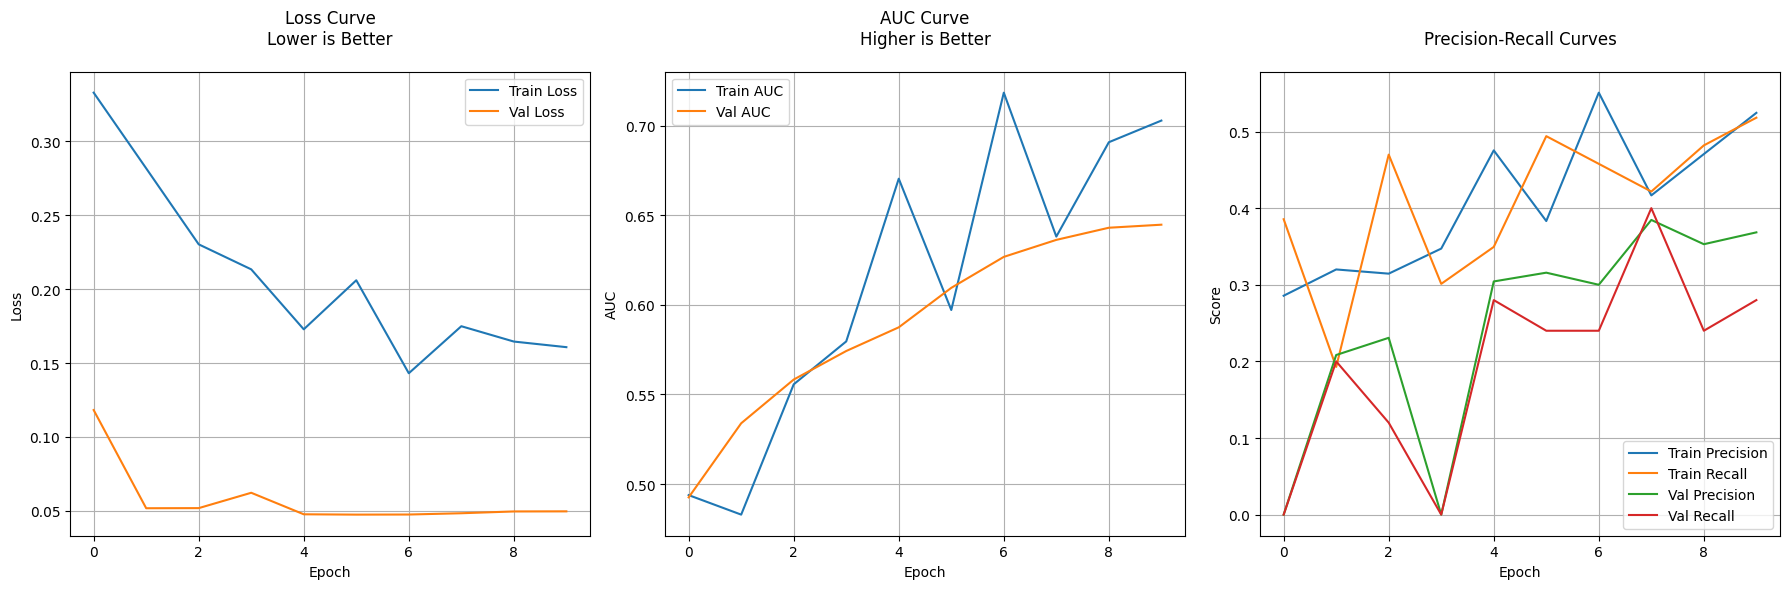

In [30]:
def plot_training_history(history):
    plt.figure(figsize=(18, 6))

    # Plot Loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss Curve\nLower is Better', pad=20)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title('AUC Curve\nHigher is Better', pad=20)
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Plot Precision-Recall
    plt.subplot(1, 3, 3)
    plt.plot(history.history['precision'], label='Train Precision')
    plt.plot(history.history['recall'], label='Train Recall')
    plt.plot(history.history['val_precision'], label='Val Precision')
    plt.plot(history.history['val_recall'], label='Val Recall')
    plt.title('Precision-Recall Curves', pad=20)
    plt.ylabel('Score')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# For phase 1 (head training)
plot_training_history(history)



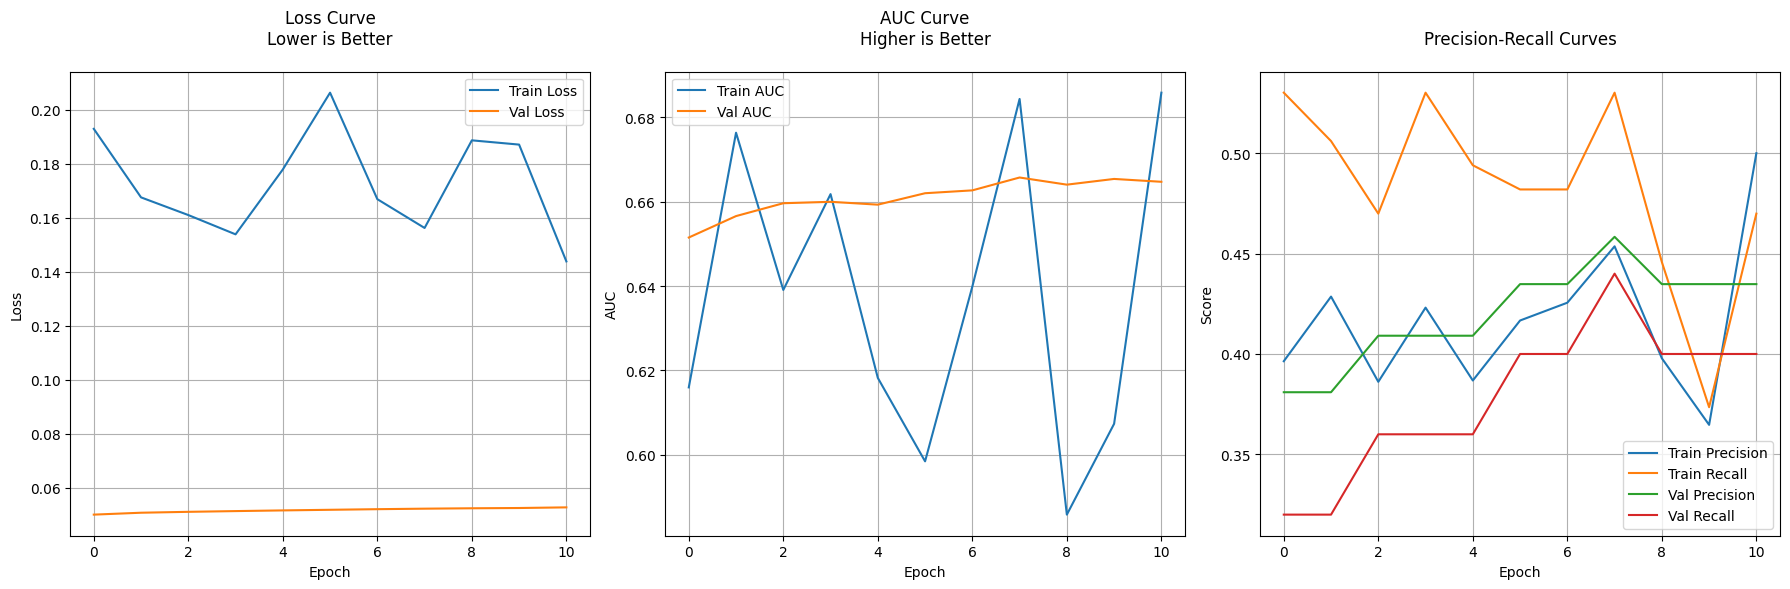

In [31]:
# For phase 2 (fine-tuning)
plot_training_history(history_fine)



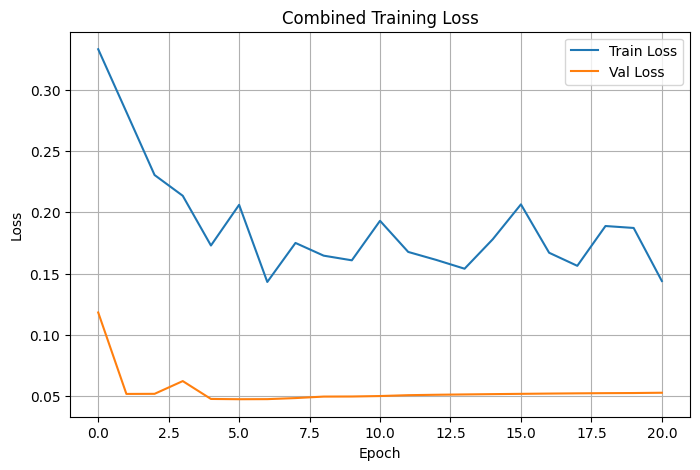

In [32]:
# Combined loss visualization
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title('Combined Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()